In [14]:
#hide
from fastbook import *
from fastai.vision.widgets import *
import shutil

In [7]:
from azure.cognitiveservices.search.imagesearch import ImageSearchClient as api
from msrest.authentication import CognitiveServicesCredentials as auth

def search_images_bing(key, term, min_sz=128, count=150):
    client = api('https://api.cognitive.microsoft.com', auth(key))
    return L(client.images.search(query=term, count=count, min_height=min_sz, min_width=min_sz).value)

# Get Data

In [8]:
key = '18a240a4d4794cbb98e53dcd80cc1afd'

In [10]:
hemsworth_bros = 'liam','luke','chris'
path = Path('images')

In [15]:
if path.exists():
    shutil.rmtree(path)

path.mkdir()
    
for h in hemsworth_bros:
    dest = (path/h)
    dest.mkdir(exist_ok=True)
    results = search_images_bing(key, f'{h} hemsworth')
    download_images(dest, urls=results.attrgot('content_url'))

In [9]:
image_paths = get_image_files(path)

In [10]:
failed = verify_images(image_paths)
len(failed)

11

In [11]:
failed.map(Path.unlink)

(#11) [None,None,None,None,None,None,None,None,None,None...]

# Train

In [20]:
hemsworths = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.2, seed=41),
    get_y = parent_label,
    item_tfms = Resize(224),
    batch_tfms = aug_transforms(mult=2))

In [21]:
dls = hemsworths.dataloaders(path)

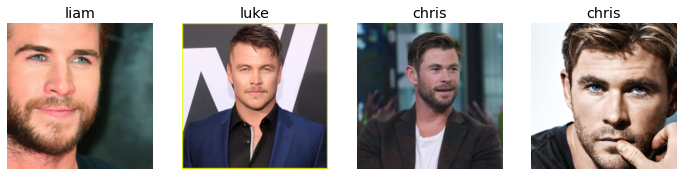

In [22]:
dls.valid.show_batch(max_n=4, nrows=1)

In [23]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)

In [24]:
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.851455,1.198252,0.602151,00:06


epoch,train_loss,valid_loss,error_rate,time
0,1.463981,0.920189,0.387097,00:08
1,1.175285,0.621596,0.236559,00:08
2,1.030521,0.535031,0.204301,00:08
3,0.906983,0.504435,0.193548,00:07


# Inspect

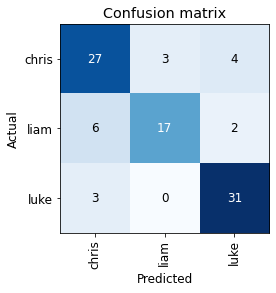

In [25]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

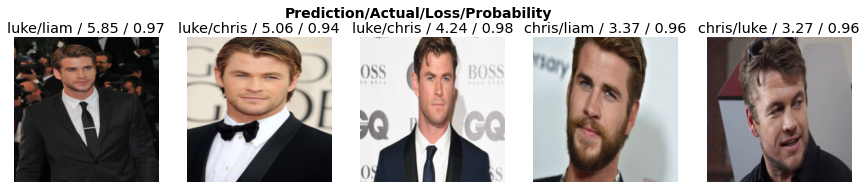

In [19]:
interp.plot_top_losses(5, nrows=1)

In [80]:
cleaner = ImageClassifierCleaner(learn)
cleaner

# Export

In [85]:
learn.export('hemsworths.pk1')